In [1]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.vis_utils import plot_model

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow
from time import time

import pandas


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data Augmentation

In [2]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_ashift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [3]:
img = load_img('/data/oxford102/jpg/image_00001.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='flower', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)


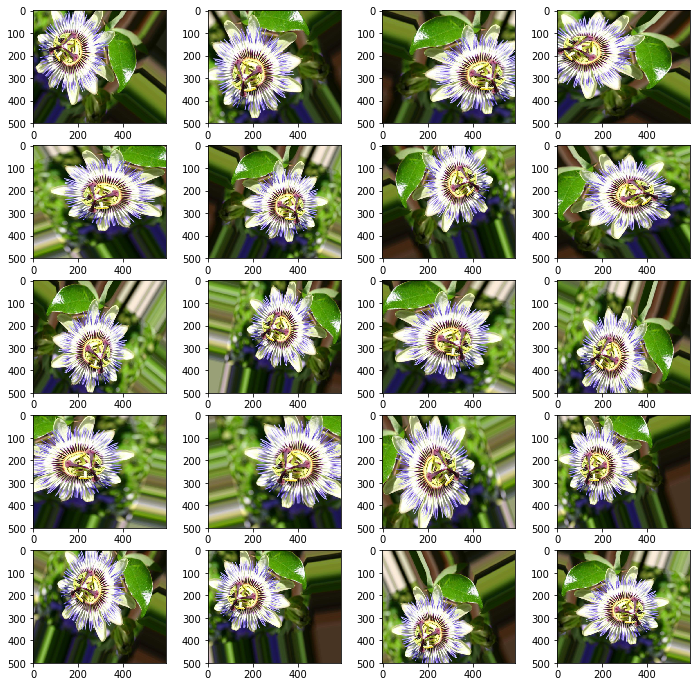

In [4]:
category = "/data/preview/"
imgs = np.random.choice(os.listdir(category), size=20, replace=False)
#os.listdir(category)

w=10
h=10
fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    #img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    img=mpimg.imread(category + imgs[i-1])
    print(img.shape)
    imgplot = plt.imshow(img)
plt.show()

# Train small convnet

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [6]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(102, activation="softmax"))
#model.add(Activation('sigmoid'))


# #Adding custom Layers 
# x = model.output
# x = Flatten()(x)
# x = Dense(1024, activation="relu")(x)
# x = Dropout(0.5)(x)
# #x = Dense(1024, activation="relu")(x)
# predictions = Dense(nr_categories, activation="softmax")(x)



model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop', 
              #optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),
              metrics=['accuracy'])

#model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 64)        18496     
__________

In [8]:
train_datagen_no_aug = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
)

In [9]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen_no_aug = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
)
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
# train_generator = train_datagen.flow_from_directory(
#         '/data/oxford102/train',  # this is the target directory
#         target_size=(150, 150),  # all images will be resized to 150x150
#         batch_size=batch_size,
#         class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# # this is a similar generator, for validation data
# validation_generator = test_datagen.flow_from_directory(
#         '/data/oxford102/val',
#         target_size=(150, 150),
#         batch_size=batch_size,
#         class_mode='categorical')

data_dir = '/data/oxford102/train'
img_width, img_height = 256, 256
batch_size = 32
epochs = 50
    
train_generator = train_datagen.flow_from_directory(
    data_dir,  # this is the target directory
    target_size=(img_width, img_height),  # all images will be resized to 250x250
    batch_size=batch_size,
    class_mode='categorical',
    subset = "training")

validation_generator = train_datagen.flow_from_directory(
    data_dir,  # this is the target directory
    target_size=(img_width, img_height),  # all images will be resized to 250x250
    batch_size=batch_size,
    class_mode='categorical',
    subset="validation")

Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.


In [25]:
checkpoint = ModelCheckpoint("/data/oxford102/small_convnet_rmsprop.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
tensorboard = TensorBoard(log_dir="logs/{}".format(time()), histogram_freq=0, write_graph=True, write_images=True)
csv_logger = CSVLogger('small_convnet_1.csv', append=True, separator=';')


In [29]:
training_params = {
    1: {'optimizer': optimizers.rmsprop, 'image_augmentation': True, "tensorboard_id":1},
    2: {'optimizer': optimizers.rmsprop, 'image_augmentation': False, "tensorboard_id":2},
    2: {'optimizer': optimizers.SGD(lr=0.0001, momentum=0.9), 'image_augmentation': True, "tensorboard_id":3},
    2: {'optimizer': optimizers.SGD(lr=0.0001, momentum=0.9), 'image_augmentation': False, "tensorboard_id":4},
}

In [15]:

plot_model(model, to_file='small_CNN.png')


In [28]:
history_callback = model.fit_generator(
        train_generator,
        steps_per_epoch=4604 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=1094 // batch_size,
        callbacks = [checkpoint, early, tensorboard, csv_logger])
#model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/50
143/143 [==============================] - 146s 1s/step - loss: 4.4320 - acc: 0.0518 - val_loss: 3.9602 - val_acc: 0.0772

Epoch 00001: val_acc improved from -inf to 0.07721, saving model to /data/oxford102/small_convnet_rmsprop.h5
Epoch 2/50
143/143 [==============================] - 137s 959ms/step - loss: 3.9140 - acc: 0.0873 - val_loss: 3.6914 - val_acc: 0.1268

Epoch 00002: val_acc improved from 0.07721 to 0.12684, saving model to /data/oxford102/small_convnet_rmsprop.h5
Epoch 3/50
143/143 [==============================] - 136s 951ms/step - loss: 3.6370 - acc: 0.1329 - val_loss: 3.3588 - val_acc: 0.1884

Epoch 00003: val_acc improved from 0.12684 to 0.18842, saving model to /data/oxford102/small_convnet_rmsprop.h5
Epoch 4/50
143/143 [==============================] - 136s 948ms/step - loss: 3.3743 - acc: 0.1738 - val_loss: 3.2978 - val_acc: 0.2022

Epoch 00004: val_acc improved from 0.18842 to 0.20221, saving model to /data/oxford102/small_convnet_rmsprop.h5
Epoch 5/50

In [40]:
pandas.DataFrame(history_callback.history).to_csv("history_small_convnet_rmsprop_50_100.csv")

In [41]:
loss_history = history_callback.history["loss"]

In [42]:
import numpy
numpy_loss_history = numpy.array(loss_history)
numpy.savetxt("loss_history_small_convnet_rmsprop_50_100.txt", numpy_loss_history, delimiter=",")

In [38]:
checkpoint = ModelCheckpoint("/data/oxford102/small_convnet_rmsprop_50_100.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
tensorboard = TensorBoard(log_dir="logs/{}".format(time()), histogram_freq=0, write_graph=True, write_images=True)
csv_logger = CSVLogger('small_convnet_1.csv', append=True, separator=';')


In [39]:
history_callback = model.fit_generator(
        train_generator,
        steps_per_epoch=4604 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=1094 // batch_size,
        callbacks = [checkpoint, early, tensorboard, csv_logger])
#model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/50
143/143 [==============================] - 138s 962ms/step - loss: 2.1866 - acc: 0.4259 - val_loss: 2.2184 - val_acc: 0.4449

Epoch 00001: val_acc improved from -inf to 0.44485, saving model to /data/oxford102/small_convnet_rmsprop_50_100.h5
Epoch 2/50
143/143 [==============================] - 136s 952ms/step - loss: 2.1981 - acc: 0.4379 - val_loss: 2.4922 - val_acc: 0.3925

Epoch 00002: val_acc did not improve from 0.44485
Epoch 3/50
143/143 [==============================] - 136s 948ms/step - loss: 2.1921 - acc: 0.4314 - val_loss: 2.2402 - val_acc: 0.4320

Epoch 00003: val_acc did not improve from 0.44485
Epoch 4/50
143/143 [==============================] - 135s 947ms/step - loss: 2.1730 - acc: 0.4242 - val_loss: 2.5977 - val_acc: 0.3869

Epoch 00004: val_acc did not improve from 0.44485
Epoch 5/50
143/143 [==============================] - 135s 943ms/step - loss: 2.1493 - acc: 0.4379 - val_loss: 2.2394 - val_acc: 0.4347

Epoch 00005: val_acc did not improve from 0.44485

In [ ]:
model.predict_classes()

In [ ]:
# no image aug

In [10]:
train_generator = train_datagen_no_aug.flow_from_directory(
    data_dir,  # this is the target directory
    target_size=(img_width, img_height),  # all images will be resized to 250x250
    batch_size=batch_size,
    class_mode='categorical',
    subset = "training")

validation_generator = train_datagen_no_aug.flow_from_directory(
    data_dir,  # this is the target directory
    target_size=(img_width, img_height),  # all images will be resized to 250x250
    batch_size=batch_size,
    class_mode='categorical',
    subset="validation")

Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.


In [11]:
epochs = 100

In [13]:
checkpoint = ModelCheckpoint("/data/oxford102/small_convnet_rmsprop_50_100_nodaug.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
tensorboard = TensorBoard(log_dir="logs/{}".format(time()), histogram_freq=0, write_graph=True, write_images=True)
csv_logger = CSVLogger('small_convnet_1b.csv', append=True, separator=';')


In [14]:
history_callback = model.fit_generator(
        train_generator,
        steps_per_epoch=4604 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=1094 // batch_size,
        callbacks = [checkpoint, early, tensorboard, csv_logger])
#model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/50
143/143 [==============================] - 67s 466ms/step - loss: 4.4103 - acc: 0.0535 - val_loss: 3.8107 - val_acc: 0.1397

Epoch 00001: val_acc improved from -inf to 0.13971, saving model to /data/oxford102/small_convnet_rmsprop_50_100_nodaug.h5
Epoch 2/50
143/143 [==============================] - 65s 456ms/step - loss: 3.6378 - acc: 0.1450 - val_loss: 3.2309 - val_acc: 0.1976

Epoch 00002: val_acc improved from 0.13971 to 0.19761, saving model to /data/oxford102/small_convnet_rmsprop_50_100_nodaug.h5
Epoch 3/50
143/143 [==============================] - 66s 461ms/step - loss: 2.9634 - acc: 0.2630 - val_loss: 2.9627 - val_acc: 0.2978

Epoch 00003: val_acc improved from 0.19761 to 0.29779, saving model to /data/oxford102/small_convnet_rmsprop_50_100_nodaug.h5
Epoch 4/50
143/143 [==============================] - 66s 463ms/step - loss: 2.2312 - acc: 0.4178 - val_loss: 2.6387 - val_acc: 0.3603

Epoch 00004: val_acc improved from 0.29779 to 0.36029, saving model to /data/oxfo

In [55]:
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

In [56]:
def preprocess_img(img):

    image=mpimg.imread(img)
    imgplot = plt.imshow(image)

    image = load_img(img, target_size=(256, 256))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # do the same preprocessing as the vgg did
    image = preprocess_input(image)
    return image

In [57]:
def predict(img_arr):
    # predict the probability across all output classes
    yhat = model.predict(img_arr)
    # convert the probabilities to class labels
    label = decode_predictions(yhat)
    # retrieve the most likely result, e.g. highest probability
    label = label[0][0]
    # print the classification
    print('%s (%.2f%%)' % (label[1], label[2]*100))

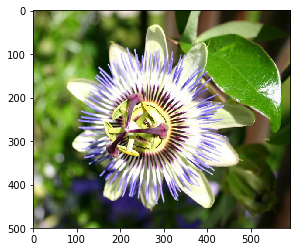

In [59]:
img = '/data/oxford102/jpg/image_00001.jpg'
image_array = preprocess_img(img)
#predict(image_array)

In [34]:
plot_model(model, to_file='baseline_CNN.png')

In [80]:
pred = model.predict_proba(image_array)

In [61]:
class_labels = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 'watercress', 'canna lily', 'hippeastrum ', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']

In [62]:
_class_labels = np.array(class_labels)

In [67]:
_class_labels

array(['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells',
       'sweet pea', 'english marigold', 'tiger lily', 'moon orchid',
       'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon',
       "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
       'globe-flower', 'purple coneflower', 'peruvian lily',
       'balloon flower', 'giant white arum lily', 'fire lily',
       'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth',
       'corn poppy', 'prince of wales feathers', 'stemless gentian',
       'artichoke', 'sweet william', 'carnation', 'garden phlox',
       'love in the mist', 'mexican aster', 'alpine sea holly',
       'ruby-lipped cattleya', 'cape flower', 'great masterwort',
       'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil',
       'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower',
       'marigold', 'buttercup', 'oxeye daisy', 'common dandelion',
       'petunia', 'wild pansy', 'primula', 'sunflower

In [79]:
for i,x in enumerate(pred[0]):
    if x == 1.0:
        print(_class_labels[i])

oxeye daisy


In [83]:
probabilities = model.predict_generator(validation_generator)

In [97]:
probabilities[1]> 0.5

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

# optimizer=SGD

In [15]:
checkpoint = ModelCheckpoint("/data/oxford102/small_convnet_sgd.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
tensorboard = TensorBoard(log_dir="logs/{}".format(time()), histogram_freq=0, write_graph=True, write_images=True)

In [16]:
model.fit_generator(
        train_generator,
        steps_per_epoch=5698 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=2441 // batch_size,
        callbacks = [checkpoint, early, tensorboard])
#model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/50
356/356 [==============================] - 114s 320ms/step - loss: 4.6108 - acc: 0.0170 - val_loss: 4.5910 - val_acc: 0.0189

Epoch 00001: val_acc improved from -inf to 0.01891, saving model to /data/oxford102/small_convnet_sgd.h5
Epoch 2/50
356/356 [==============================] - 114s 320ms/step - loss: 4.5813 - acc: 0.0242 - val_loss: 4.5587 - val_acc: 0.0362

Epoch 00002: val_acc improved from 0.01891 to 0.03618, saving model to /data/oxford102/small_convnet_sgd.h5
Epoch 3/50
356/356 [==============================] - 114s 319ms/step - loss: 4.5638 - acc: 0.0251 - val_loss: 4.5389 - val_acc: 0.0354

Epoch 00003: val_acc did not improve from 0.03618
Epoch 4/50
356/356 [==============================] - 114s 320ms/step - loss: 4.5526 - acc: 0.0270 - val_loss: 4.5243 - val_acc: 0.0329

Epoch 00004: val_acc did not improve from 0.03618
Epoch 5/50
356/356 [==============================] - 114s 319ms/step - loss: 4.5374 - acc: 0.0297 - val_loss: 4.5045 - val_acc: 0.0391

Ep

356/356 [==============================] - 113s 319ms/step - loss: 3.2517 - acc: 0.1984 - val_loss: 3.0567 - val_acc: 0.2562

Epoch 00036: val_acc improved from 0.25452 to 0.25617, saving model to /data/oxford102/small_convnet_sgd.h5
Epoch 37/50
356/356 [==============================] - 112s 315ms/step - loss: 3.1939 - acc: 0.2214 - val_loss: 3.0105 - val_acc: 0.2599

Epoch 00037: val_acc improved from 0.25617 to 0.25987, saving model to /data/oxford102/small_convnet_sgd.h5
Epoch 38/50
356/356 [==============================] - 112s 313ms/step - loss: 3.1559 - acc: 0.2221 - val_loss: 2.9975 - val_acc: 0.2627

Epoch 00038: val_acc improved from 0.25987 to 0.26275, saving model to /data/oxford102/small_convnet_sgd.h5
Epoch 39/50
356/356 [==============================] - 111s 311ms/step - loss: 3.1410 - acc: 0.2323 - val_loss: 2.9733 - val_acc: 0.2854

Epoch 00039: val_acc improved from 0.26275 to 0.28536, saving model to /data/oxford102/small_convnet_sgd.h5
Epoch 40/50
356/356 [=======

# With Data augmentation

In [23]:
checkpoint = ModelCheckpoint("/data/oxford102/small_convnet_rmsprop_more_augmentation.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
tensorboard = TensorBoard(log_dir="logs/{}".format(time()), histogram_freq=0, write_graph=True, write_images=True)
model.fit_generator(
        train_generator,
        steps_per_epoch=5698 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=2441 // batch_size,
        callbacks = [checkpoint, early, tensorboard])
#model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/50
356/356 [==============================] - 115s 323ms/step - loss: 4.2427 - acc: 0.0620 - val_loss: 3.7434 - val_acc: 0.1172

Epoch 00001: val_acc improved from -inf to 0.11719, saving model to /data/oxford102/small_convnet_rmsprop_more_augmentation.h5
Epoch 2/50
356/356 [==============================] - 115s 324ms/step - loss: 3.6455 - acc: 0.1178 - val_loss: 3.2986 - val_acc: 0.1945

Epoch 00002: val_acc improved from 0.11719 to 0.19449, saving model to /data/oxford102/small_convnet_rmsprop_more_augmentation.h5
Epoch 3/50
356/356 [==============================] - 115s 322ms/step - loss: 3.3467 - acc: 0.1733 - val_loss: 3.0784 - val_acc: 0.2484

Epoch 00003: val_acc improved from 0.19449 to 0.24836, saving model to /data/oxford102/small_convnet_rmsprop_more_augmentation.h5
Epoch 4/50
356/356 [==============================] - 115s 322ms/step - loss: 3.1507 - acc: 0.2242 - val_loss: 3.4569 - val_acc: 0.2270

Epoch 00004: val_acc did not improve from 0.24836
Epoch 5/50
356/